In [1]:
# Montamos nuestro google drive en el colab

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Llevamos el repositorio a nuestro drive

In [2]:
# Clonamos el repo para usar el codigo de la lib
!git clone https://github.com/elsonidoq/ml-practico-2022.git
!cd ml-practico-2022; git pull

Cloning into 'ml-practico-2022'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 395 (delta 54), reused 49 (delta 23), pack-reused 313
Receiving objects: 100% (395/395), 4.85 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (245/245), done.
Already up to date.


In [3]:
import sys
sys.path.append('ml-practico-2022')

# Loading the data

In [4]:
from lib import model, data

In [7]:
from pathlib import Path

# Para trabajar en colab
PATH = Path('/content/gdrive/My Drive/ml-practico-data/')

In [8]:
movies = data.load_data(PATH)

Loading title basics...


ml-practico-2022/lib/data.py:70: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  title_basics = load_title_basics(path)


Loading title ratings...
Loading movie directors...
Merging everything...


In [9]:
train_df = movies[movies.startYear <= 2017]
test_df = movies[movies.startYear > 2017]

len(train_df), len(test_df), len(test_df) / len(train_df)

(286002, 39839, 0.13929622869770142)

In [10]:
y_train = train_df.averageRating
y_test = test_df.averageRating

X_train = train_df.to_dict(orient='records')
X_test = test_df.to_dict(orient='records')

# Modelling per se

### Armamos todos los problemas de clasificacion

In [11]:
import numpy as np

thresholds = np.linspace(1.5, 9.5, 15)
thresholds

array([1.5       , 2.07142857, 2.64285714, 3.21428571, 3.78571429,
       4.35714286, 4.92857143, 5.5       , 6.07142857, 6.64285714,
       7.21428571, 7.78571429, 8.35714286, 8.92857143, 9.5       ])

In [12]:
# El punto medio entre cada par de threshold, util para graficar
mids = [(t0 + t1)/2 for t0, t1 in zip(thresholds[:-1], thresholds[1:])]

In [13]:
def get_bools(y):
    res = []
    for t in thresholds:
        res.append(y <= t)
    return res

ys_train = get_bools(y_train)
ys_test = get_bools(y_test)

### Armamos los modelos

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

models = [
    model.get_model_pipe(
        features_pipe=model.get_features_pipe(
            use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
        ),
        model=LogisticRegression()   
    )
    for _ in range(len(thresholds))
]

### Entrenamos

In [15]:
for i, m in enumerate(models):
    print(i)
    m.fit(X_train, ys_train[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Visualizamos los modelos

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

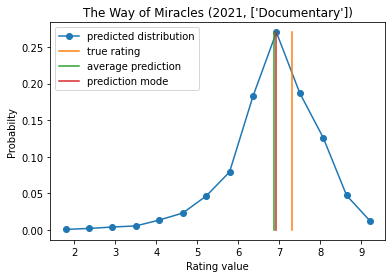

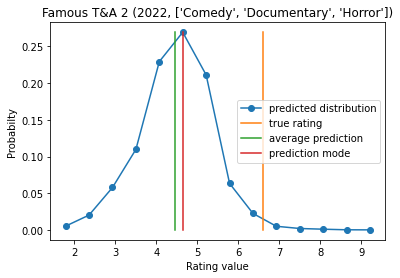

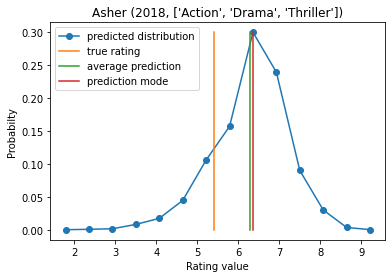

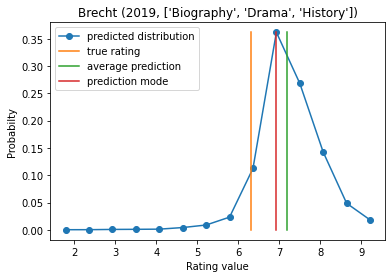

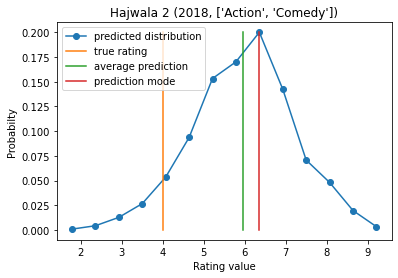

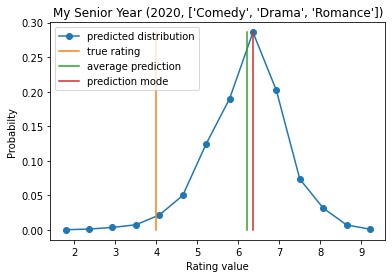

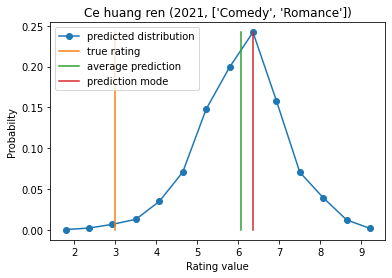

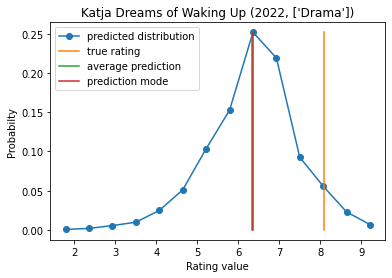

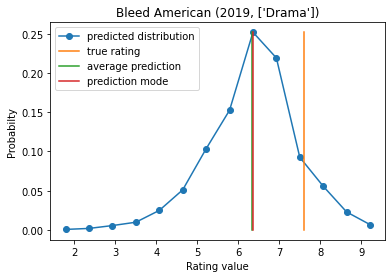

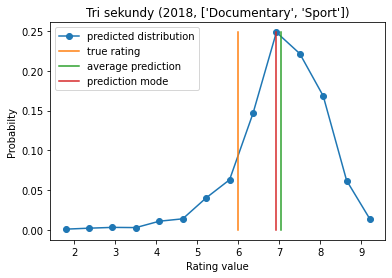

In [17]:
dt = X_test
y_dt = y_test

for _ in range(10):
    i = randint(0, len(dt))

    plt.figure()
    plt.title('{originalTitle} ({startYear:.00f}, {genres})'.format(**dt[i]))
    preds = np.asarray([m.predict_proba([dt[i]])[0,1] for m in models])
    preds = preds[1:] - preds[:-1]

    plt.plot(mids, preds, '-o', label='predicted distribution')
    plt.plot([y_dt.iloc[i], y_dt.iloc[i]], [0, preds.max()], label='true rating')
    plt.plot([(preds * mids).sum(), (preds * mids).sum()], [0, preds.max()], label='average prediction')
    plt.plot([mids[preds.argmax()], mids[preds.argmax()]], [0, preds.max()], label='prediction mode')
    plt.legend(loc='best')
    plt.xlabel('Rating value')
    plt.ylabel('Probabilty')
    

# Para pensar

Pensando en el contexto de querer brindar una herramienta que guie la construccion de guiones

* Nos da algún tipo de ventaja para construir un mejor producto esta técnica?
* Qué metrica offline podemos usar para evaluar este modelo?
* Habría una ventaja de utilizar un modelo basado en arboles?
* Para leer: Cómo se podría empaquetar este código en algo compatible con sklearn.linear_models.LogisticRegression? 